In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
import albumentations as A
import os
import json
from PIL import Image
import numpy as np
import cv2
from scipy.ndimage import center_of_mass
import itertools
from sklearn.model_selection import train_test_split

c:\Users\nphie\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('./data/default.json') as f:
    data = json.load(f)
items = data['items']

train_val_items, test_items = train_test_split(items, test_size=0.1, random_state=42)
train_items, val_items = train_test_split(train_val_items, test_size=0.1, random_state=42)

In [3]:
transform_train = A.Compose([
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-10, 10), shear=(-5, 5), p=0.7),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

transform_val = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,  )),
    ToTensorV2()
])

In [4]:
class CervicalDataset(Dataset):
    def __init__(self, items, img_dir, image_size=(256, 256), transform=None, num_landmarks=4):
        self.items = items
        self.img_dir = img_dir
        self.image_size = image_size
        self.transform = transform
        self.num_landmarks = num_landmarks

    def __len__(self):
        return len(self.items)

    def _generate_heatmap(self, points, height, width, sigma=4):
        heatmaps = np.zeros((self.num_landmarks, height, width), dtype=np.float32)
        for i, (x, y) in enumerate(points):
            if x < 0 or y < 0:
                continue
            xx, yy = np.meshgrid(np.arange(width), np.arange(height))
            heatmaps[i] = np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
        return heatmaps

    def __getitem__(self, idx):
        item = self.items[idx]
        image_name = item['id']
        img_path = os.path.join(self.img_dir, image_name + '.png')
        image = Image.open(img_path).convert("L")
        image = np.array(image)

        h_ori, w_ori = image.shape
        h, w = self.image_size
        
        keypoints = [(-1, -1)] * self.num_landmarks
        for ann in item['annotations']:
            if ann['type'] != 'points':
                continue
            lid = ann['label_id']
            x, y = ann['points']
            if lid == 1:
                keypoints[0] = (x * w / w_ori, y * h / h_ori)
            elif lid == 2:
                keypoints[1] = (x * w / w_ori, y * h / h_ori)
            elif lid == 21:
                keypoints[2] = (x * w / w_ori, y * h / h_ori)
            elif lid == 22:
                keypoints[3] = (x * w / w_ori, y * h / h_ori)

        image = cv2.resize(image, (w, h))

        heatmaps = self._generate_heatmap(keypoints, h, w)

        conf_map = np.zeros((2, h, w), dtype=np.float32)
        if all([kp[0] >= 0 for kp in keypoints]):
            line1 = cv2.line(np.zeros((h, w), dtype=np.uint8),
                            tuple(np.round(keypoints[0]).astype(int)),
                            tuple(np.round(keypoints[1]).astype(int)), 1, 1)
            line2 = cv2.line(np.zeros((h, w), dtype=np.uint8),
                            tuple(np.round(keypoints[2]).astype(int)),
                            tuple(np.round(keypoints[3]).astype(int)), 1, 1)
            conf_map[0] = line1
            conf_map[1] = line2

        target = np.concatenate([heatmaps, conf_map], axis=0)

        if self.transform:
            augmented = self.transform(image=image, mask=target.transpose(1, 2, 0))
            image = augmented['image']
            target = augmented['mask'].permute(2, 0, 1)

        return image, target
        

In [5]:
img_path = "./data/images"
train_dataset = CervicalDataset(train_items, img_path, transform=transform_train)
val_dataset = CervicalDataset(val_items, img_path, transform=transform_val)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [1]:
import segmentation_models_pytorch as smp

c:\Users\nphie\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
model = smp.DeepLabV3Plus(
    encoder_name='efficientnet-b4',
    encoder_weights='imagenet',
    activation=None,
    in_channels=1,
    classes=6
)
model = model.cuda().eval()

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

In [7]:
def get_max_location(heatmap):
    y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    return np.array([x, y], dtype=np.float32)

def get_keypoints_from_heatmap(heatmaps):
    return [get_max_location(heatmap) for heatmap in heatmaps]

def compute_nme(pred_keypoints, gt_keypoints):
    pred_keypoints = np.array(pred_keypoints)
    gt_keypoints = np.array(gt_keypoints)

    error = np.linalg.norm(pred_keypoints - gt_keypoints, axis=1)
    norm = np.linalg.norm(gt_keypoints[0] - gt_keypoints[-1]) + 1e-6
    return np.mean(error) / norm

def extract_keypoints_from_heatmap(heatmap):
    all_candidates = heatmap_to_candidates(heatmap)
    keypoints = []
    best_scores = []

    for i in range(2):
        c1s, c2s = all_candidates[2 * i], all_candidates[2 * i + 1]
        if not c1s or not c2s:
            keypoints.extend([(0, 0), (0, 0)])
            best_scores.append(0.0)
            continue

        scores = []
        pairs = []
        conf_map = heatmap[4 + i]
        for c1, c2 in itertools.product(c1s, c2s):
            line = np.zeros_like(conf_map)
            p1 = tuple(np.round(c1).astype(int))
            p2 = tuple(np.round(c2).astype(int))
            cv2.line(line, p1, p2, 1, 3)
            score = (conf_map * line).sum() / (line.sum() + 1e-6)
            scores.append(score)
            pairs.append((c1, c2))
        best = pairs[np.argmax(scores)]
        best_scores.append(np.max(scores))
        keypoints.extend(best)
    return keypoints, best_scores

def heatmap_to_candidates(heatmap):
    all_candidates = []
    for ch in heatmap[:4]:
        max_val = ch.max()
        if max_val <= 0:
            raise RuntimeError('Empty heatmap')
        thresh = max_val / 2
        labels = (ch >= thresh).astype(np.uint8)
        labeled = cv2.connectedComponentsWithStats(labels, 8, cv2.CV_32S)[1]
        candidates = []
        for i in range(1, labeled.max() + 1):
            mask = (labeled == i)
            center = center_of_mass(ch * mask)
            candidates.append(center[::-1])  # (x, y)
        all_candidates.append(candidates)
    return all_candidates

In [12]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(loader):
        images = images.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    nmes = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.cuda()
            targets = targets.cuda()
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            
            for i in range(images.size(0)):
                pred_heatmap = outputs[i, :6].cpu().numpy()
                gt_heatmap = targets[i, :4].cpu().numpy()

                pred_kps, _ = extract_keypoints_from_heatmap(pred_heatmap)
                gt_kps = get_keypoints_from_heatmap(gt_heatmap)

                nme = compute_nme(pred_kps, gt_kps)
                nmes.append(nme)
    return (running_loss / len(loader.dataset), np.mean(nmes))

In [13]:
num_epochs = 200
patience = 8
epoch_without_improvement = 0
best_val_loss = float('inf')

for param in model.encoder.parameters():
    param.requires_grad = False

for epoch in range(num_epochs):
    if epoch == 10:
        print("Unfreezing encoder...")
        for param in model.encoder.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, mean_nme = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | NME: {mean_nme:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epoch_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model!")
    else:
        epoch_without_improvement += 1
        if epoch_without_improvement > patience:
            break
        

  1%|          | 5/503 [00:07<12:34,  1.52s/it]


KeyboardInterrupt: 

In [7]:
def calculate_cobb_angle(keypoints):
    c2_a, c2_p, c7_a, c7_p = keypoints
    vec1 = np.array(c2_a) - np.array(c2_p)
    vec2 = np.array(c7_a) - np.array(c7_p)

    vec1 = vec1 / np.linalg.norm(vec1)
    vec2 = vec2 / np.linalg.norm(vec2)
    
    dot_product = np.dot(vec1, vec2)
    dot_product = np.clip(dot_product, -1.0, 1.0)
    angle_rad = np.arccos(dot_product)
    
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg 

In [8]:
def print_heatmap_patch(heatmap, pred, c, patch_size = 10):
    x, y = map(int, pred)
    half = patch_size // 2
    
    h, w = heatmap.shape[1:]  # assuming shape is (C, H, W)

    # Clamp to stay within bounds
    x1 = max(0, x - half)
    x2 = min(w, x + half + 1)
    y1 = max(0, y - half)
    y2 = min(h, y + half + 1)

    patch = heatmap[c, y1:y2, x1:x2]
    print(f"Patch around point ({x}, {y}) in channel {c}:")
    print(np.round(patch, 3))

C:\Users\nphie\AppData\Local\Temp\ipykernel_7736\885368400.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..255.0].


[array([97., 56.], dtype=float32), array([117.,  55.], dtype=float32), array([100., 172.], dtype=float32), array([127., 170.], dtype=float32)]


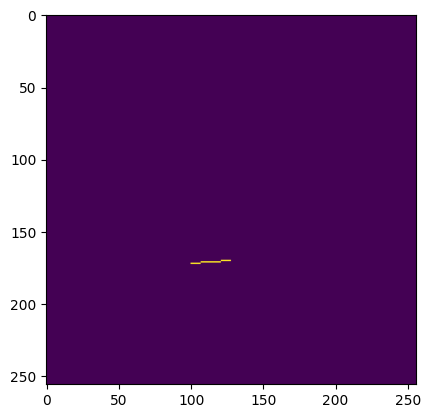

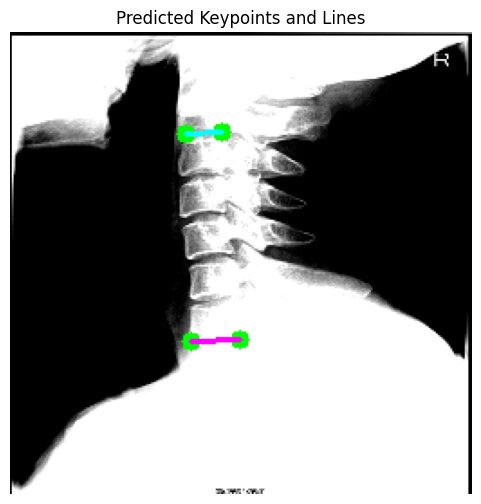

Landmark 0: (97.0, 56.0) | Score: 0.144
Landmark 1: (117.0, 55.0) | Score: 0.183


In [149]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

model = smp.DeepLabV3Plus(
    encoder_name='efficientnet-b4',
    encoder_weights=None,
    activation=None,
    in_channels=1,
    classes=6
)
model.load_state_dict(torch.load('./best_model (3).pth'))
model = model.cuda().eval()

def inference(model, image_tensor, device='cuda'):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.float().unsqueeze(0).to(device)
        
        output = model(image_tensor)
        heatmap = output.squeeze(0).cpu().numpy()
    keypoints, scores = extract_keypoints_from_heatmap(heatmap)
    return keypoints, scores, heatmap

def draw_predicted_keypoints(image_tensor, keypoints, radius=5, color=(0, 255, 0), thickness=2):
    image = image_tensor.squeeze().cpu().numpy()
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for (x, y) in keypoints:
        if x >= 0 and y >= 0:
            cv2.circle(image_color, (int(x), int(y)), radius, color, -1)

    if keypoints[0][0] >= 0 and keypoints[1][0] >= 0:
        cv2.line(image_color, tuple(np.int32(keypoints[0])), tuple(np.int32(keypoints[1])), (0, 255, 255), thickness)
    if keypoints[2][0] >= 0 and keypoints[3][0] >= 0:
        cv2.line(image_color, tuple(np.int32(keypoints[2])), tuple(np.int32(keypoints[3])), (255, 0, 255), thickness)

    return image_color

test_dataset = CervicalDataset(test_items, img_path, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
image, target = next(iter(test_loader))
image_tensor = image[0]
keypoints_2 = get_keypoints_from_heatmap(target[0,:4])
print(keypoints_2)
keypoints, scores, heatmap = inference(model, image_tensor)

# keypoints = refine_keypoints_with_local_max(heatmap, keypoints)
overlay = draw_predicted_keypoints(image_tensor, keypoints)

plt.imshow(target[0,5])

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title("Predicted Keypoints and Lines")
plt.axis("off")
plt.show()

for i, (pt, score) in enumerate(zip(keypoints, scores)):
    print(f"Landmark {i}: ({pt[0]:.1f}, {pt[1]:.1f}) | Score: {score:.3f}")



In [2]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,], std=[0.229,])
])

def predict_cobb_from_image(image_path, model, device='cuda', image_size=(256, 256), visualize=True):
    image = Image.open(image_path).convert("L")
    image = np.array(image)
    orig_image = image.copy()
    
    image_resized = cv2.resize(image, image_size)
    
    image_tensor = transform(Image.fromarray(image_resized)).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        heatmap = output.squeeze(0).cpu().numpy()

    keypoints, _ = extract_keypoints_from_heatmap(heatmap)

    def angle_between(p1, p2):
        delta = np.array(p2) - np.array(p1)
        angle = np.arctan2(delta[1], delta[0]) * 180 / np.pi
        return angle
    
    angle1 = angle_between(keypoints[0], keypoints[1])
    angle2 = angle_between(keypoints[2], keypoints[3])
    cobb_angle = abs(angle1 - angle2)
    
    if visualize:
        image_color = cv2.cvtColor(cv2.resize(orig_image, image_size), cv2.COLOR_GRAY2BGR)
        for (x, y) in keypoints:
            cv2.circle(image_color, (int(x), int(y)), 4, (0, 255, 0), -1)
        cv2.line(image_color, tuple(np.int32(keypoints[0])), tuple(np.int32(keypoints[1])), (0, 255, 255), 2)
        cv2.line(image_color, tuple(np.int32(keypoints[2])), tuple(np.int32(keypoints[3])), (255, 0, 255), 2)
        cv2.putText(image_color, f"Cobb: {cobb_angle:.2f} deg", (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        plt.imshow(image_color)
        plt.title("Predicted Cobb Angle")
        plt.axis("off")
        plt.show()

    return cobb_angle, keypoints


In [3]:
import matplotlib.pyplot as plt

In [11]:
model = smp.DeepLabV3Plus(
    encoder_name='efficientnet-b4',
    encoder_weights=None,
    activation=None,
    in_channels=1,
    classes=6
)
model = model.cuda().eval()
model.load_state_dict(torch.load("./best_model (3).pth"))

<All keys matched successfully>

In [13]:
model_3 = smp.DeepLabV3Plus(
    encoder_name='efficientnet-b4',
    encoder_weights=None,
    activation=None,
    in_channels=1,
    classes=6
)
model_3 = model_3.cuda().eval()
model_3.load_state_dict(torch.load("./best_model (3).pth"))

<All keys matched successfully>

In [4]:
from model import DeepLabV3Plus
model_2 = DeepLabV3Plus()

model_2 = model_2.cuda().eval()
model_2.load_state_dict(torch.load("./best_model (3).pth"))

<All keys matched successfully>

In [ ]:
model_2.cuda().eval()

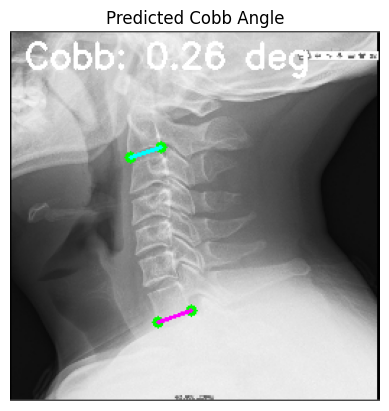

Predicted Cobb Angle: 0.257462301386024


In [ ]:
cobb_angle, keypoints = predict_cobb_from_image("C:/Users/nphie/OneDrive/Documents/PoseNet/data/images/0001035.png", model_2, device='cuda')
print("Predicted Cobb Angle:", cobb_angle)

In [193]:
def get_ten_highest_loss(dataloader, device='cuda'):
    import torch
    import segmentation_models_pytorch as smp
    from tqdm import tqdm
    import numpy as np
    import matplotlib.pyplot as plt

    model = smp.DeepLabV3Plus(
        encoder_name='efficientnet-b4',
        encoder_weights=None,
        activation=None,
        in_channels=1,
        classes=6
    )
    model.load_state_dict(torch.load('./best_model (3).pth'))
    model = model.to(device).eval()

    highest_losses = []
    id = 0
    with torch.no_grad():
        for img, targets in tqdm(dataloader):  
            img, targets = img.to(device), targets.to(device)
            output = model(img)

            # Giả sử batch size = 1
            pred = output[0].detach().cpu()
            target = targets[0].detach().cpu()
            pred = pred[:6]
            target = target[:4]
            pred = pred.squeeze(0).numpy()
            target = target.squeeze(0).numpy()
            keypoints, _ = extract_keypoints_from_heatmap(pred)
            keypoints_2 = get_keypoints_from_heatmap(target)

            cob_angle_pred = calculate_cobb_angle([keypoints[0], keypoints[1], keypoints[2], keypoints[3]])
            cob_angle_real = calculate_cobb_angle([keypoints_2[0], keypoints_2[1], keypoints_2[2], keypoints_2[3]])
            loss = float(abs(cob_angle_real - cob_angle_pred))

            highest_losses.append({
                'loss': loss,
                'img': img[0].detach().cpu(),
                'pred_angle': cob_angle_pred,
                'real_angle': cob_angle_real,
                'pred_keypoints': keypoints,
                'gt_keypoints': keypoints_2,
                'id': id * 8
            })
            id += 1

    # Sort and average loss
    highest_losses.sort(key=lambda x: x['loss'], reverse=True)
    loss_values = [x['loss'] for x in highest_losses]
    avg_loss = np.mean(loss_values)

   
    for i, entry in enumerate(highest_losses[:30]):
        img = entry['img'].numpy().squeeze()
        pred_angle = entry['pred_angle']
        real_angle = entry['real_angle']
        loss = entry['loss']
        pred_kps = entry['pred_keypoints']
        gt_kps = entry['gt_keypoints']
        id = entry['id']

        plt.figure(figsize=(5, 5))
        plt.imshow(img, cmap='gray')
        
        # Plot predicted keypoints (blue)
        for (x, y) in pred_kps:
            label = 'Pred' if (x, y) == tuple(pred_kps[0]) else ""
            plt.scatter(x, y, color='blue', marker='o', s=40, label=label)

        # Plot ground truth keypoints (red)
        for (x, y) in gt_kps:
            label = 'GT' if (x, y) == tuple(gt_kps[0]) else ""
            plt.scatter(x, y, color='red', marker='x', s=40, label=label)

        plt.title(f"#{i+1} | GT: {real_angle:.2f}° | Pred: {pred_angle:.2f}° | Loss: {loss:.2f}° | ID: {id:.2f}")
        plt.axis('off')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()



    return highest_losses[:20], avg_loss


100%|██████████| 63/63 [00:14<00:00,  4.32it/s]


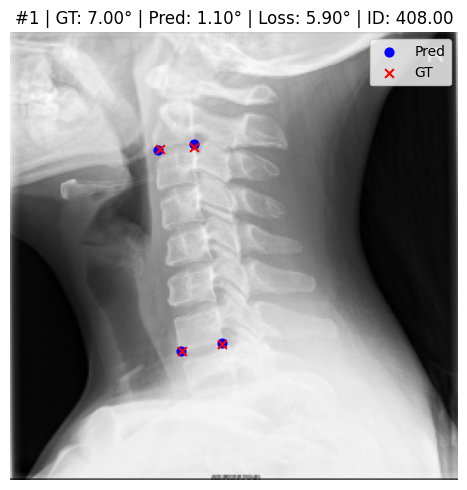

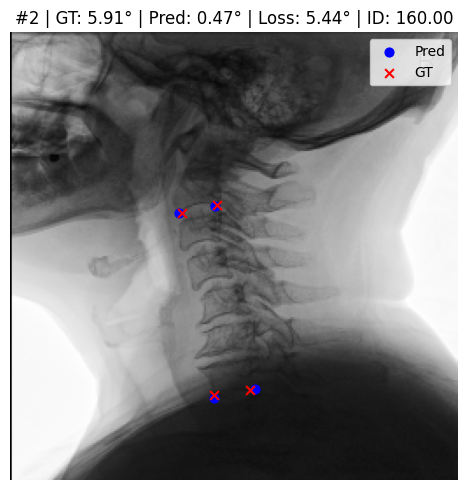

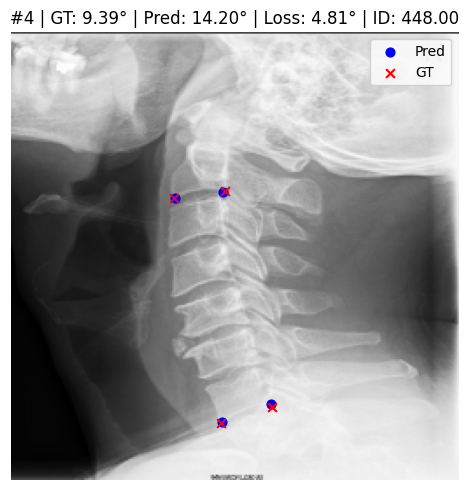

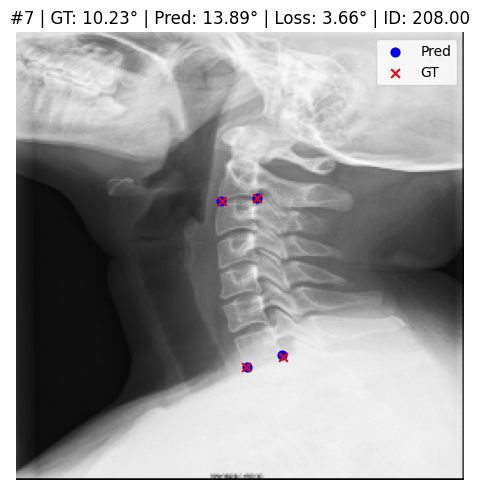

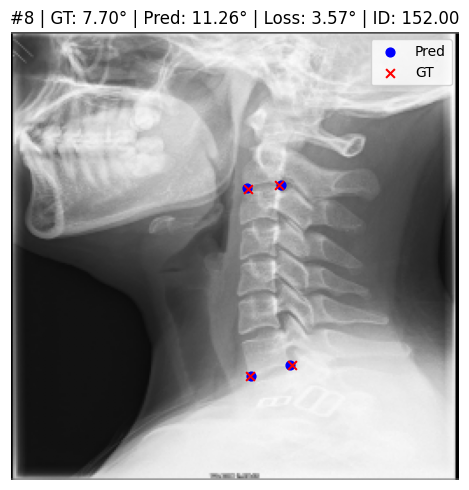

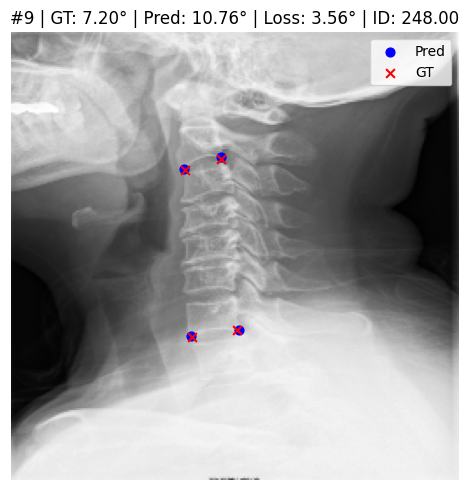

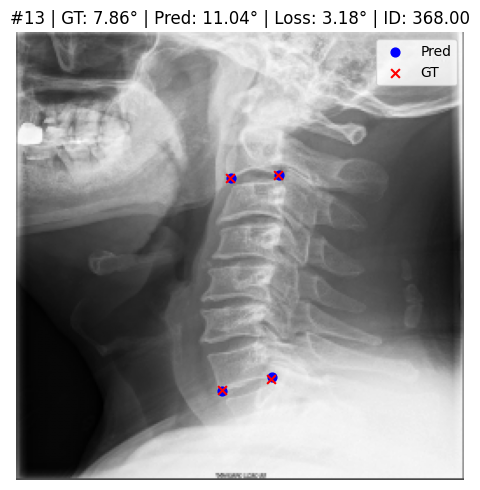

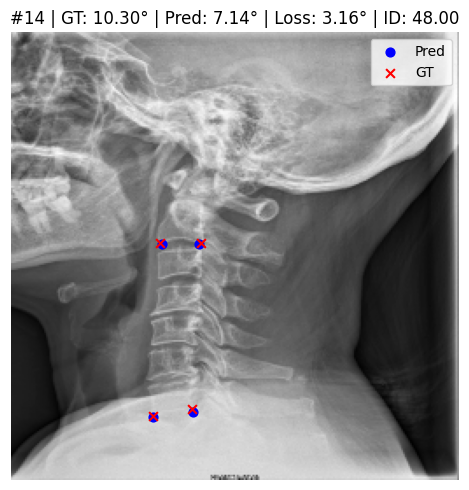

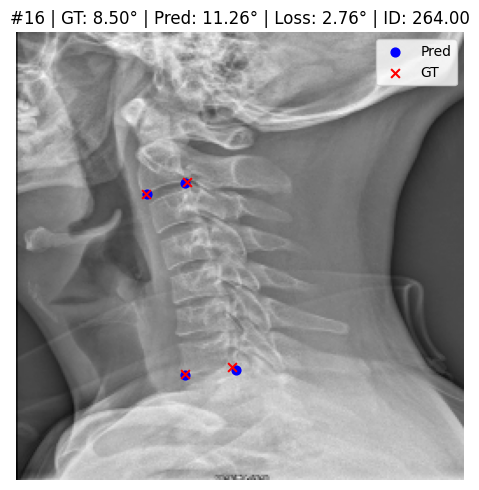

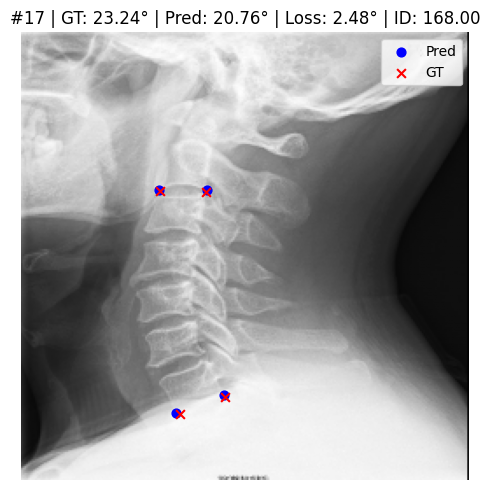

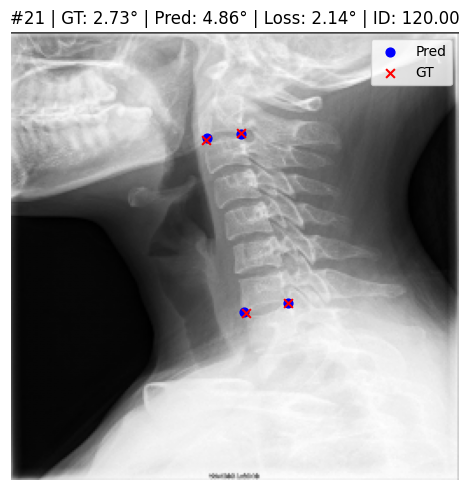

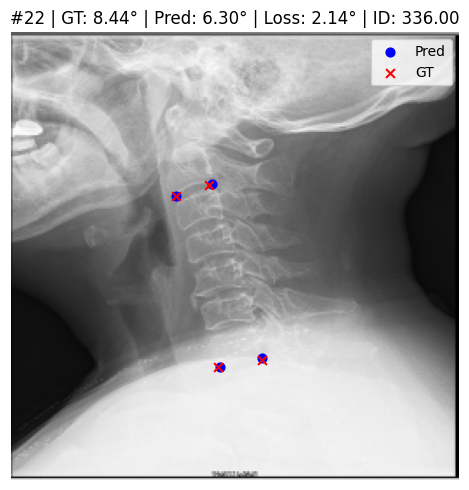

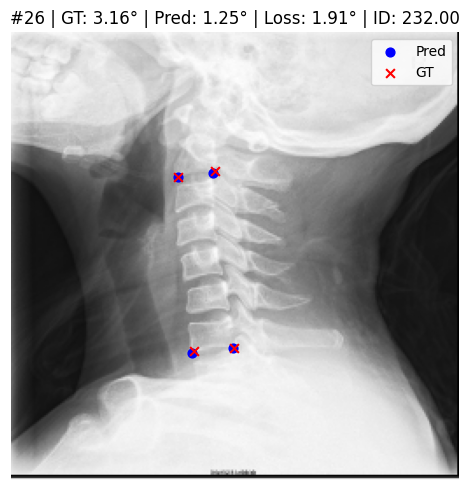

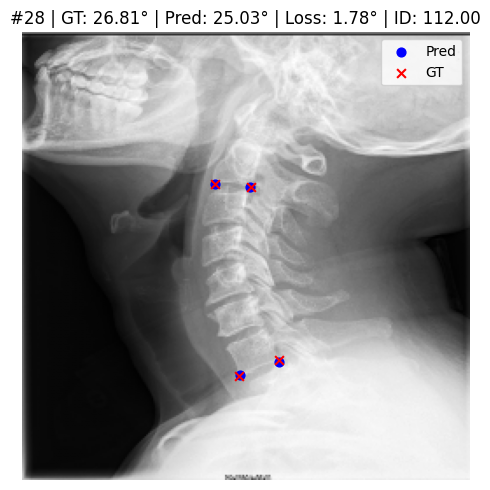

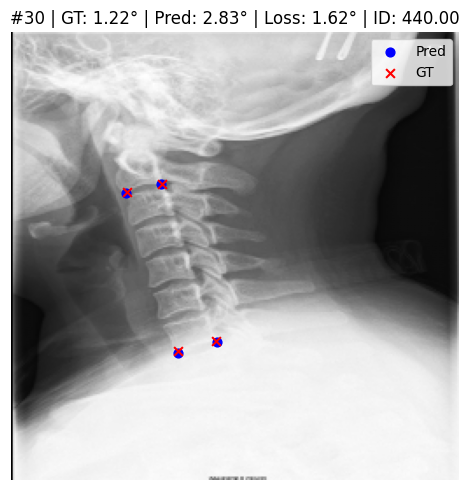

In [194]:
a = get_ten_highest_loss(test_loader)

In [195]:
a

([{'loss': 5.902830169443155,
   'img': tensor([[[ 1.4783,  1.3242,  1.2557,  ..., -0.8507, -0.0287,  1.1015],
            [ 1.6667,  1.4954,  1.4269,  ..., -0.9877, -0.2171,  1.4269],
            [ 1.4783,  1.3413,  1.2899,  ..., -1.0733, -0.3198,  1.3927],
            ...,
            [ 1.2899, -0.0458, -0.7822,  ...,  1.2214,  1.2214,  1.2557],
            [ 1.2728, -0.0629, -0.6281,  ...,  1.2385,  1.3070,  1.3413],
            [-0.7650, -1.2617, -1.4843,  ..., -0.7308, -0.7308, -0.7137]]]),
   'pred_angle': np.float64(1.1005639574489348),
   'real_angle': np.float32(7.003394),
   'pred_keypoints': [(np.float64(84.18747702719286),
     np.float64(66.73687948934318)),
    (np.float64(104.51178660508076), np.float64(63.57028212090258)),
    (np.float64(97.33692213120514), np.float64(181.50109171328867)),
    (np.float64(120.79569850835597), np.float64(177.38314564855867))],
   'gt_keypoints': [array([85., 66.], dtype=float32),
    array([105.,  65.], dtype=float32),
    array([ 98., 

([(np.float64(86.00531726076406), np.float64(67.13466170832358)), (np.float64(104.74423700726211), np.float64(64.01865223059151)), (np.float64(97.40880191314758), np.float64(181.32333911811128)), (np.float64(120.35548146023133), np.float64(177.15529523991228))], [np.float32(0.15102349), np.float32(0.16106522)])
[array([85., 66.], dtype=float32), array([105.,  65.], dtype=float32), array([ 98., 182.], dtype=float32), array([121., 178.], dtype=float32), array([96., 65.], dtype=float32), array([119., 178.], dtype=float32)]


C:\Users\nphie\AppData\Local\Temp\ipykernel_7736\2598178064.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)


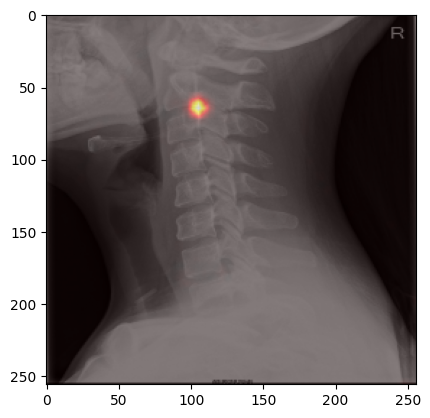

In [191]:
img_tensor = test_loader.dataset[408][0]
target = test_loader.dataset[408][1]

img_np = img_tensor.squeeze().cpu().numpy()
img_np_uint8 = (img_np * 255).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_np_uint8)  # still shape: (H, W)

img_clahe_tensor = torch.from_numpy(img_clahe.astype(np.float32) / 255.0).unsqueeze(0)

img_input = img_clahe_tensor.unsqueeze(0).cuda() 

model.eval()
with torch.no_grad():
    output = model(img_input)
    heatmap = output.squeeze(0).cpu().numpy()
    keypoints = extract_keypoints_from_heatmap(heatmap)
    keypoints_2 = get_keypoints_from_heatmap(target)

plt.imshow(img_tensor.cpu().squeeze(), cmap='grey')
plt.imshow(heatmap[1], cmap='hot', alpha=0.5)

print(keypoints)
print(keypoints_2)